### Цели и описание проекта

**Описание проекта:** **Прогнозирование цен на автомобили**

Цель данного проекта заключается в разработке модели для предсказания цен на автомобили на основе различных характеристик, таких как мощность двигателя, год выпуска, пробег, марка и модель. Компания, занимающаяся продажей автомобилей, стремится автоматизировать процесс оценки стоимости автомобилей, чтобы улучшить принятие решений и оптимизировать процесс продажи. Использование машинного обучения позволяет повысить точность оценок и ускорить процесс принятия решений.

**Цель исследования:** Разработать модель для предсказания цен на автомобили, используя исторические данные о продажах, характеристики автомобилей и другие факторы. Модель должна эффективно оценивать стоимость автомобилей с учетом различных факторов, таких как год выпуска, мощность, пробег, и другие важные признаки.

**Ход исследования:**

1. **Загрузка данных:**
   Анализ данных из таблиц, содержащих информацию о продаже автомобилей. Включены признаки, такие как мощность, год регистрации, пробег, модель, бренд и другие. Также были загружены дополнительные метки времени и данные о фотографиях автомобилей.


2. **Предобработка данных:**
   - Изменены типы данных для корректного представления дат и времени.
   - Пропуски в данных были обработаны с использованием заглушек ('unknown') для текстовых данных, таких как бренд или модель автомобиля.
   - Были удалены полные дубли и обнаружены выбросы, которые также были обработаны: выбросы в столбцах с мощностью и годом регистрации были заменены медианными значениями по группам, а выбросы в столбце регистрации года были удалены.


3. **Исследовательский анализ данных:**
   Проведен анализ признаков и их взаимосвязей с ценой. Были выявлены ключевые признаки, влияющие на цену, такие как модель, мощность двигателя, пробег и год выпуска. Были удалены ненужные признаки, такие как дата загрузки, дата создания и количество фотографий, которые не оказывали значительного влияния на предсказания.


4. **Подготовка данных для моделей:**
   - Применены методы кодирования категориальных признаков, такие как OneHotEncoding для модели и бренда, а также нормализация и масштабирование числовых признаков для улучшения качества модели.
   - Признаки, такие как бренд и модель, были преобразованы для устранения мультиколлинеарности, что позволило улучшить производительность моделей.


5. **Обучение моделей:**
   - Обучены несколько моделей: градиентный бустинг (LightGBM), линейная регрессия (LinearRegression), метод опорных векторов (SVR) и случайный лес (RandomForestRegressor).
   - Модели были оценены по метрике RMSE, с наилучшими результатами, показанными градиентным бустингом (LightGBM), который показал RMSE 1730.
   - Время обучения и предсказания также было учтено, и был сделан вывод, что модель градиентного бустинга является оптимальной по качеству и времени работы.

**Выводы и рекомендации приведены в конце проекта.**

### Загрузка и предобработка данных

In [ ]:
!pip install sweetviz phik lightgbm python-Levenshtein -q

In [ ]:
import pandas as pd
import sweetviz as sv
import lightgbm as lgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from Levenshtein import distance
from rapidfuzz import process, fuzz
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', parse_dates=['DateCrawled', 'LastSeen', 'DateCreated'])
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
310323,2016-03-13 11:42:02,400,NaN,1990,manual,75,jetta,150000,2,NaN,volkswagen,yes,2016-03-13,0,4299,2016-03-20 13:48:21
17742,2016-03-19 08:52:08,150,small,1998,manual,66,megane,150000,10,NaN,renault,yes,2016-03-19,0,91413,2016-04-06 07:17:44
74391,2016-03-07 05:36:22,24,sedan,1998,manual,102,3er,125000,12,petrol,bmw,NaN,2016-03-07,0,63911,2016-03-16 05:16:41
195370,2016-03-28 22:52:32,14000,wagon,2007,auto,235,5er,150000,5,gasoline,bmw,no,2016-03-28,0,93073,2016-04-05 12:46:02
307522,2016-04-01 09:51:40,16900,sedan,2009,manual,245,3er,150000,5,gasoline,bmw,no,2016-04-01,0,82515,2016-04-07 06:46:20


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [ ]:
df_shape = df.shape[0]

In [ ]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
298441,2016-03-12 16:42:43,700,sedan,1997,manual,122,c_klasse,150000,1,petrol,mercedes_benz,no,2016-03-12,0,57462,2016-04-01 09:45:14
105333,2016-03-11 19:38:56,600,small,1997,manual,51,polo,150000,0,petrol,volkswagen,yes,2016-03-11,0,46045,2016-03-17 06:17:25
56759,2016-03-21 17:37:43,1500,sedan,1997,manual,125,a4,150000,1,petrol,audi,no,2016-03-21,0,33142,2016-03-21 17:37:43
222782,2016-03-26 20:58:30,500,small,2000,manual,54,corsa,150000,6,petrol,opel,no,2016-03-26,0,55130,2016-03-30 08:46:14
143889,2016-03-25 19:46:36,8900,convertible,1998,manual,192,z_reihe,150000,10,petrol,bmw,no,2016-03-25,0,85221,2016-04-03 00:45:21


In [ ]:
cat_columns = df.select_dtypes(include=['object'])
for col in cat_columns:
  print(col, ':', df[col].unique(), '\n')

VehicleType : [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] 

Gearbox : ['manual' 'auto' nan] 

Model : ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spide

In [ ]:
for model_name in df['Model'].unique():
    for model_name_2 in df['Model'].unique():
        model_name = str(model_name)
        model_name_2 = str(model_name_2)
        lev_dist = distance(model_name, model_name_2)
        if lev_dist < 2 and model_name!=model_name_2:
            print(
                model_name,
                model_name_2
            )

3er 5er
3er 1er
3er 7er
3er 6er
2_reihe 3_reihe
2_reihe z_reihe
2_reihe i_reihe
2_reihe 6_reihe
2_reihe 5_reihe
2_reihe 1_reihe
2_reihe 4_reihe
2_reihe x_reihe
2_reihe c_reihe
2_reihe m_reihe
c_max s_max
c_max b_max
3_reihe 2_reihe
3_reihe z_reihe
3_reihe i_reihe
3_reihe 6_reihe
3_reihe 5_reihe
3_reihe 1_reihe
3_reihe 4_reihe
3_reihe x_reihe
3_reihe c_reihe
3_reihe m_reihe
a_klasse e_klasse
a_klasse b_klasse
a_klasse c_klasse
a_klasse s_klasse
a_klasse v_klasse
a_klasse m_klasse
a_klasse g_klasse
5er 3er
5er 1er
5er 7er
5er 6er
c4 a4
c4 c1
c4 c3
c4 c5
c4 cc
c4 cl
c4 c2
e_klasse a_klasse
e_klasse b_klasse
e_klasse c_klasse
e_klasse s_klasse
e_klasse v_klasse
e_klasse m_klasse
e_klasse g_klasse
1er 3er
1er 5er
1er 7er
1er 6er
b_klasse a_klasse
b_klasse e_klasse
b_klasse c_klasse
b_klasse s_klasse
b_klasse v_klasse
b_klasse m_klasse
b_klasse g_klasse
a8 a4
a8 a1
a8 a6
a8 a3
a8 a2
a8 a5
c_klasse a_klasse
c_klasse e_klasse
c_klasse b_klasse
c_klasse s_klasse
c_klasse v_klasse
c_klasse m_kla

In [ ]:
pd.set_option('display.max_rows', None)
df['Model'].value_counts().sort_index()

100                     417
145                      49
147                     572
156                     629
159                     212
1_reihe                1306
1er                    3514
200                      18
2_reihe                4816
300c                    145
3_reihe                3493
3er                   19761
4_reihe                 638
500                     920
5_reihe                 442
5er                    7868
601                     419
6_reihe                1278
6er                     156
7er                    1017
80                     1604
850                     212
90                      103
900                     116
9000                     31
911                      84
a1                      595
a2                      373
a3                     6122
a4                     9900
a5                      545
a6                     5541
a8                      529
a_klasse               4193
accord                  351
agila               

In [ ]:
pd.reset_option('display.max_rows')

In [ ]:
df['FuelType'] = df['FuelType'].replace({'petrol': 'gasoline'})
df['Model'] = df['Model'].replace({'rangerover': 'range_rover'})

Обнаружены и заменены неявные дубли 'petrol' и 'gasoline', 'rangerover' и 'range_rover'

In [ ]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [ ]:
df = df.fillna('other')
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Данные признаки с пропусками уже содержат значение 'other', логично пропуски заполнить заглушкой 'other', чтобы слишком много данных не удалять

#### Выводы по разделу "Загрузка и предобработка данных"

1. **Изменение типов данных**:
   - Изменение типов данных не потребовалось, за исключением столбцов **'DateCrawled'**, **'LastSeen'**, **'DateCreated'**, которые были переведены в формат **datetime** при загрузке.
   

2. **Обнаружение и удаление дубликатов**:
   - Были обнаружены и удалены **неявные дубликаты** в признаках модель и тип топливо
   - Полный дубликаты будут удалены после выявления неважных признаков в данных

   

3. **Заполнение пропусков**:
   - Пропущенные значения были заполнены заглушкой **'unknown'**



### Исследовательский анализ данных

In [ ]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


                                             |          | [  0%]   00:00 -> (? left)


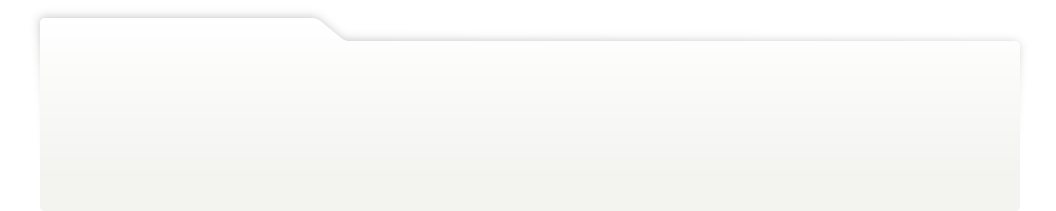
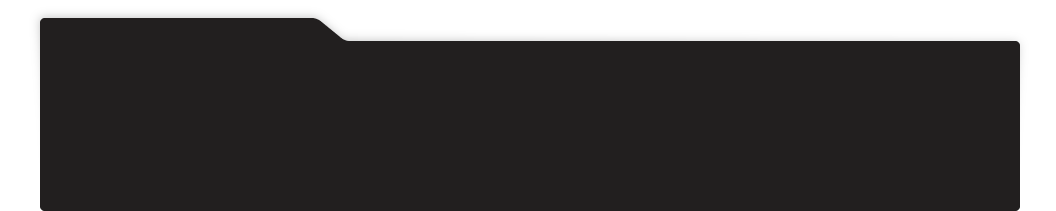
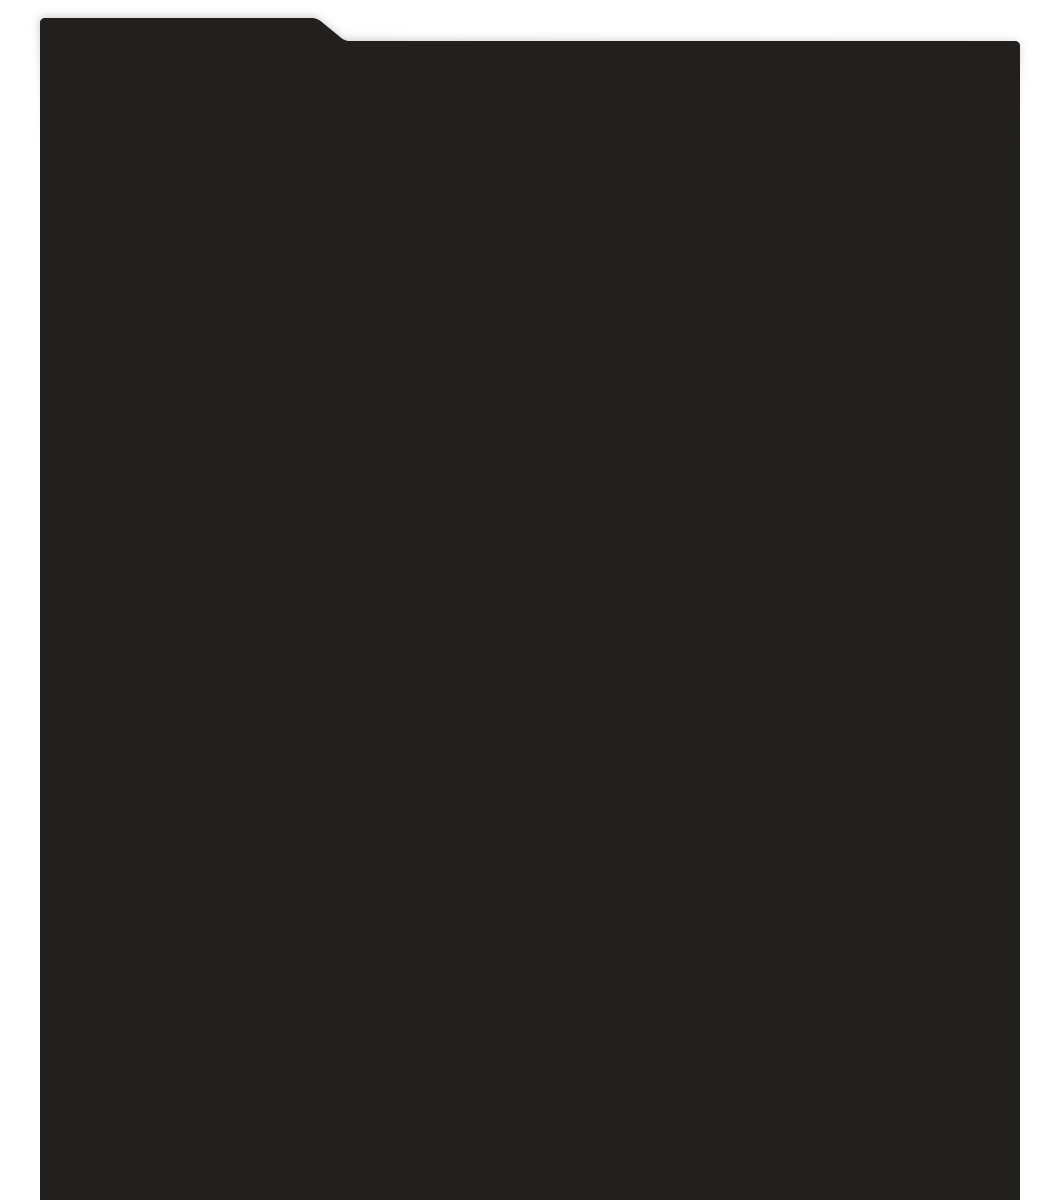
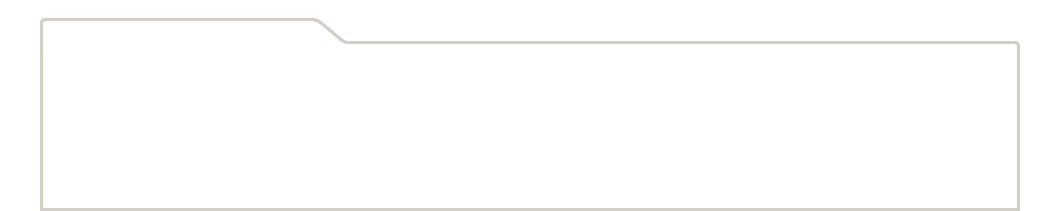
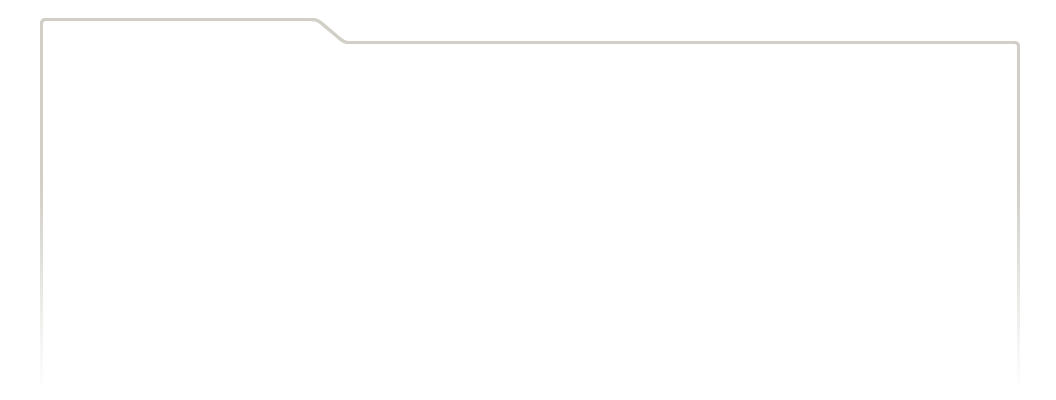
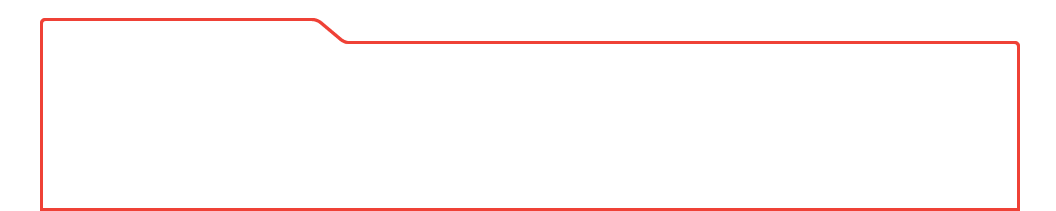
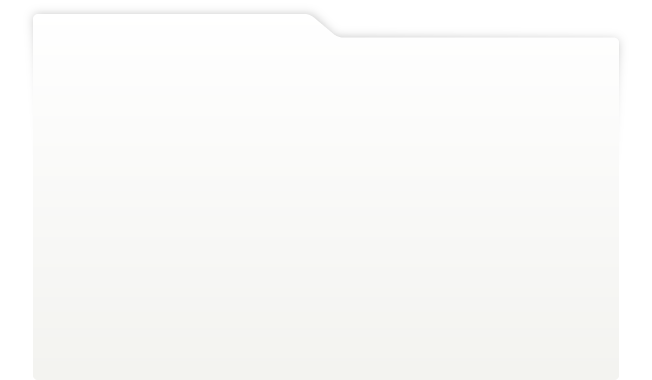
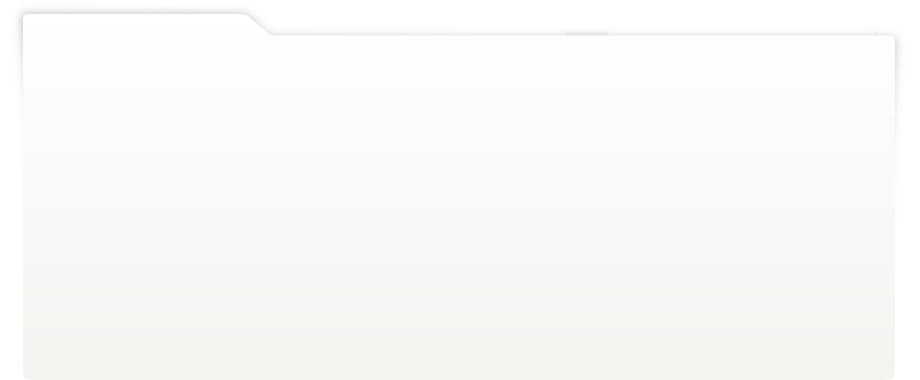
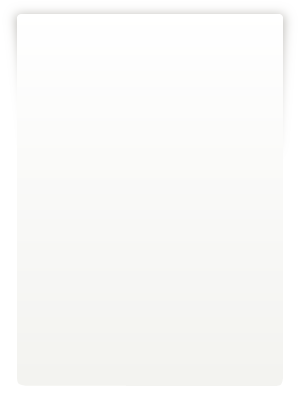
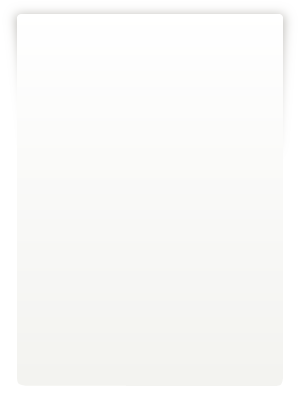
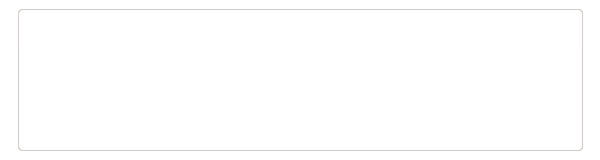
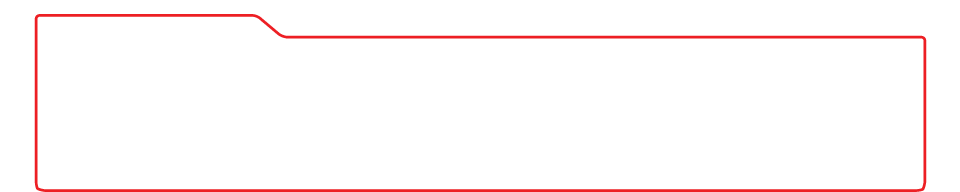
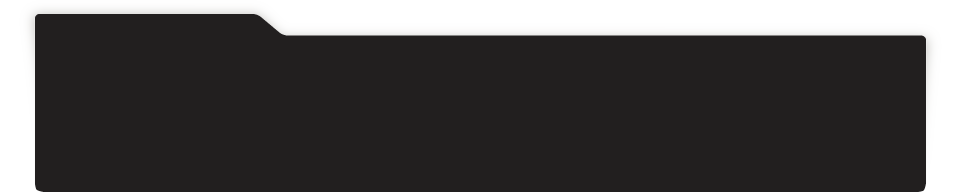
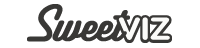
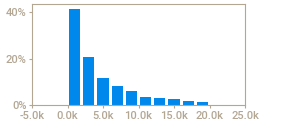
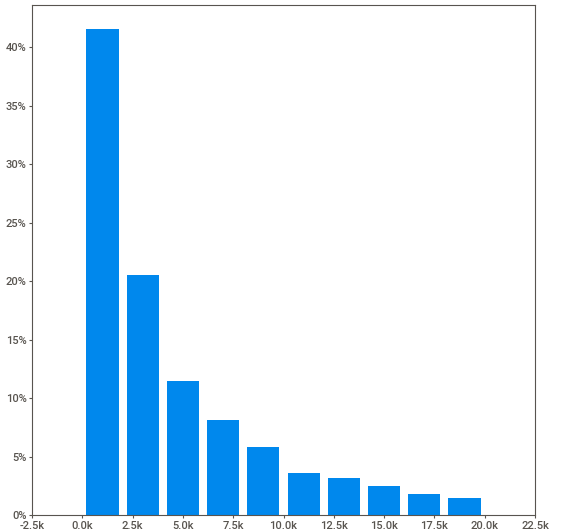
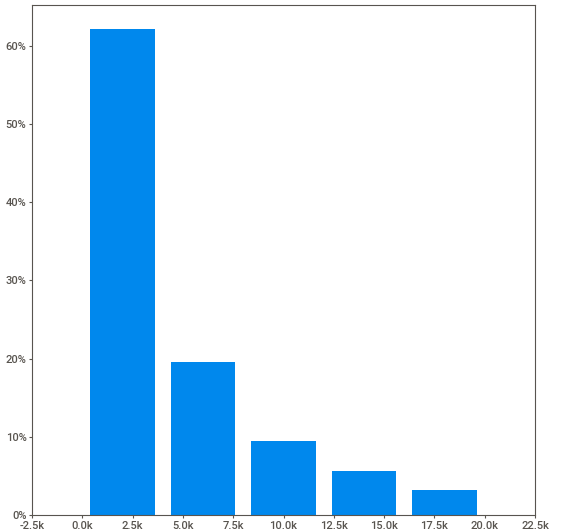
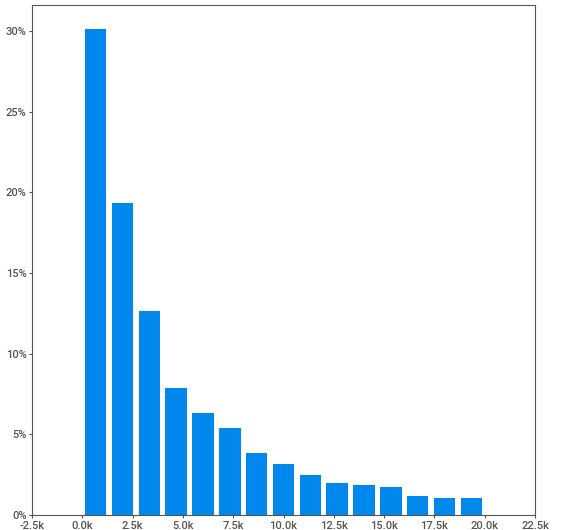
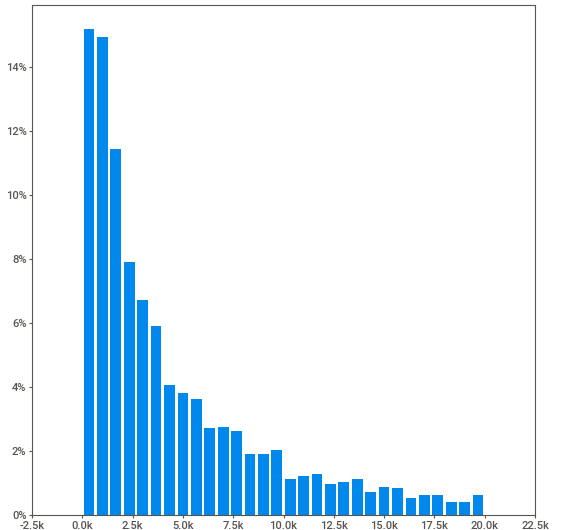
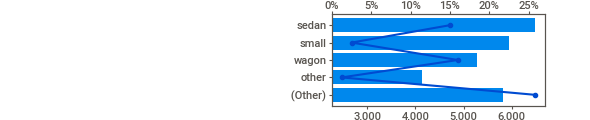
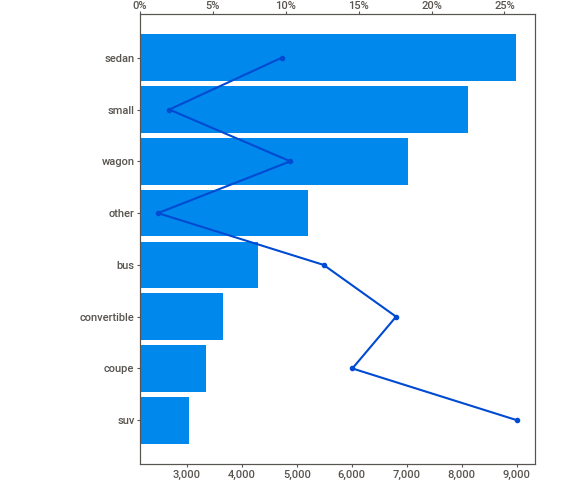
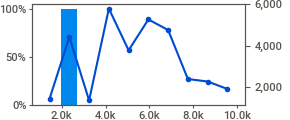
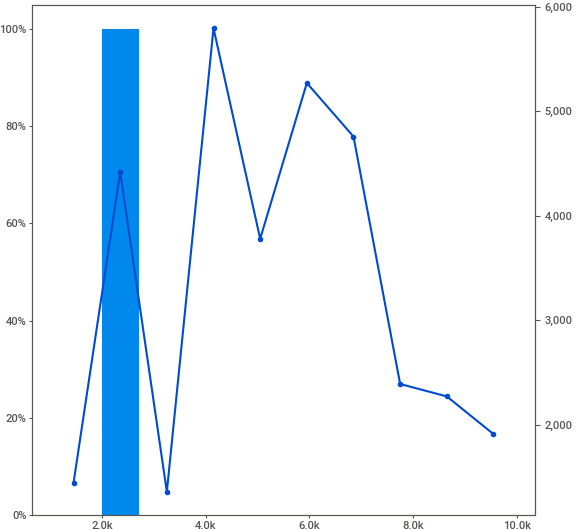
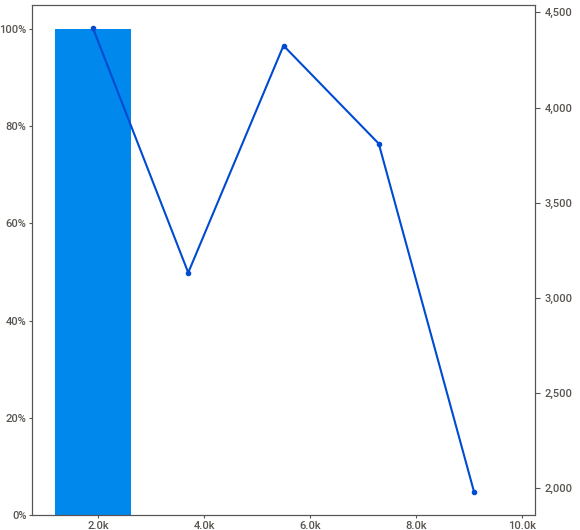
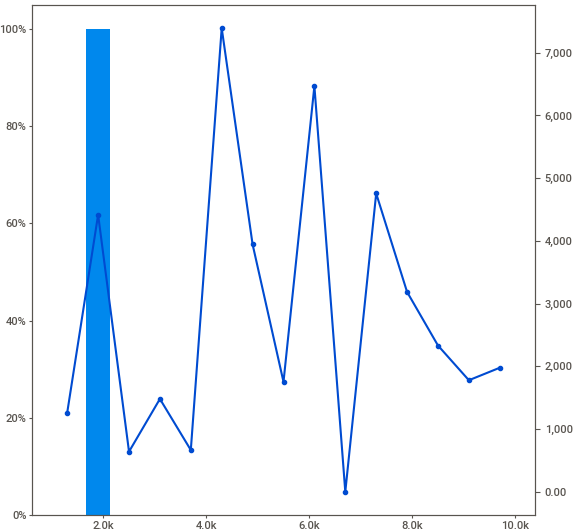
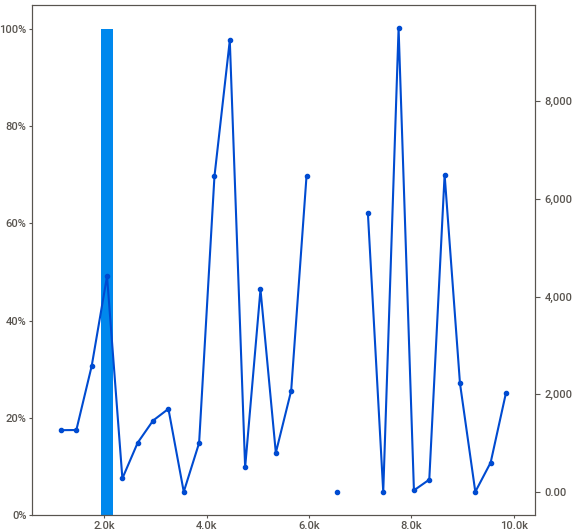
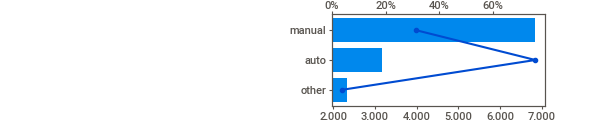
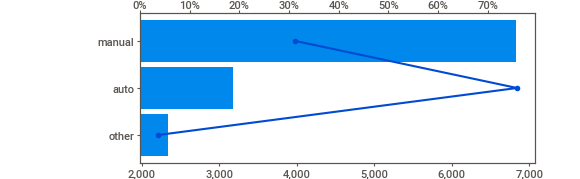
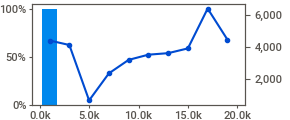
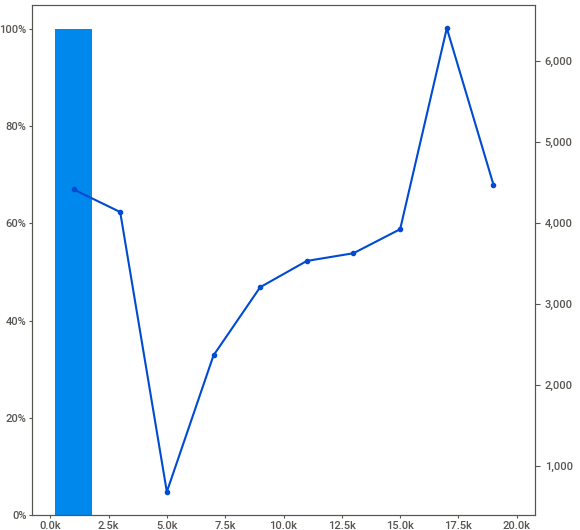
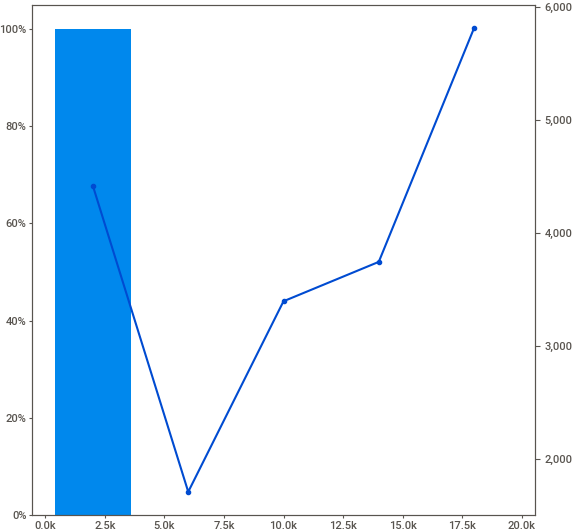
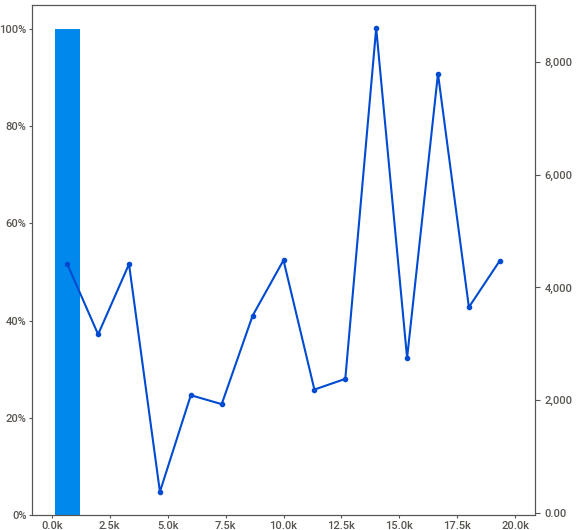
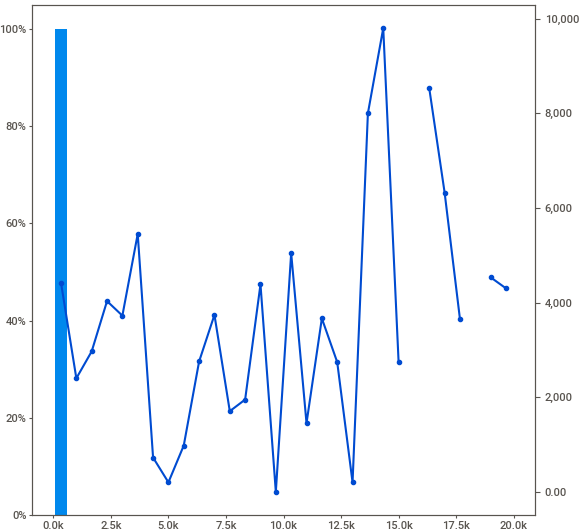
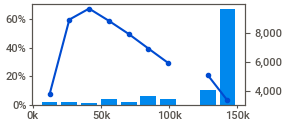
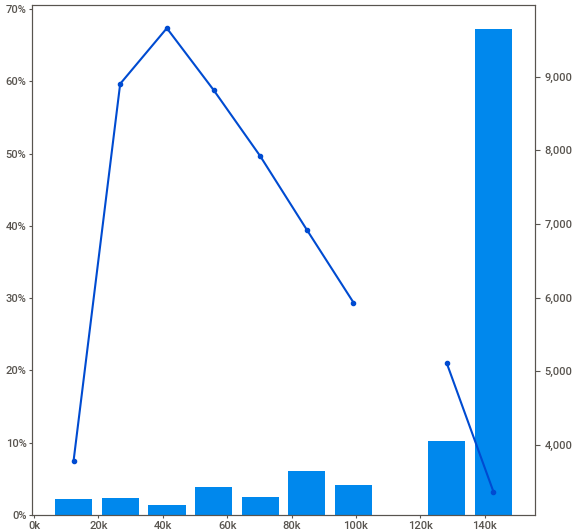
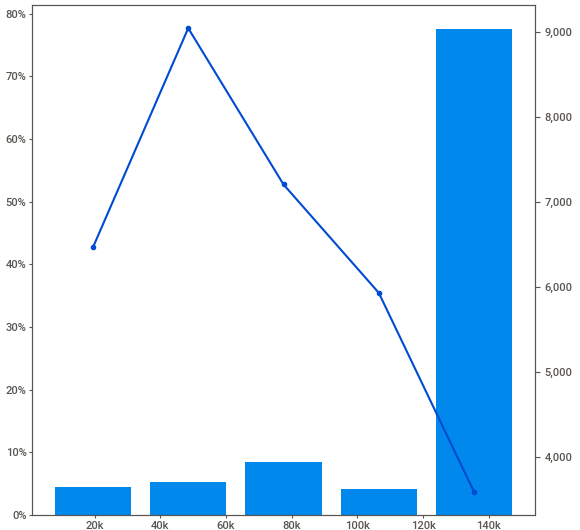
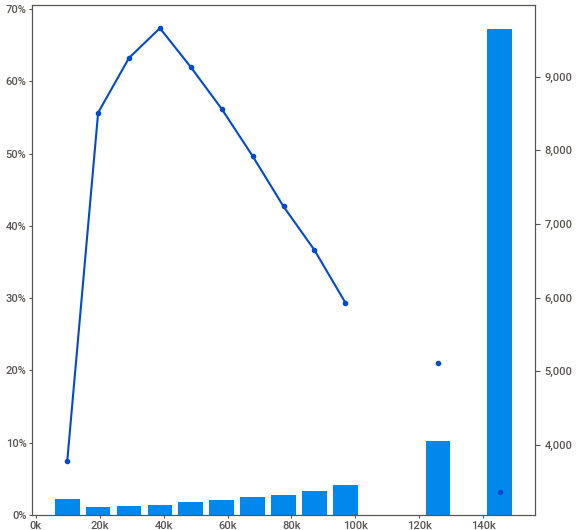
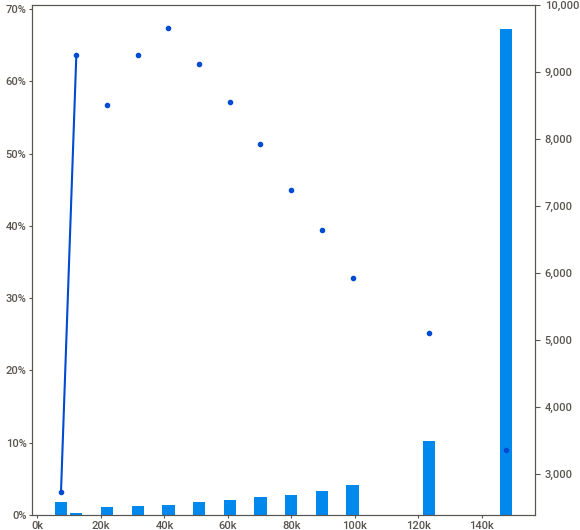
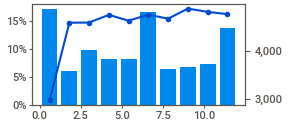
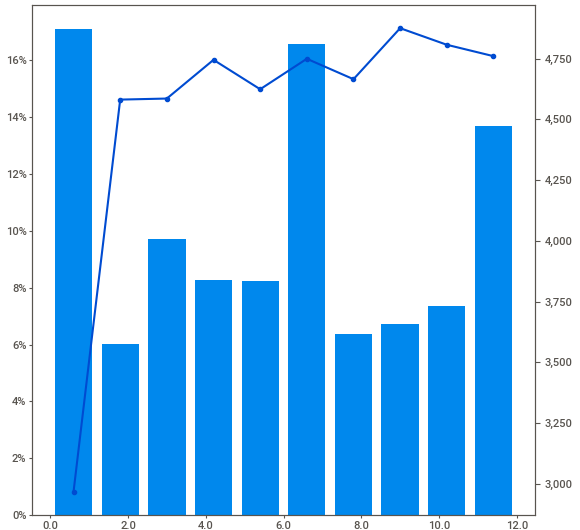
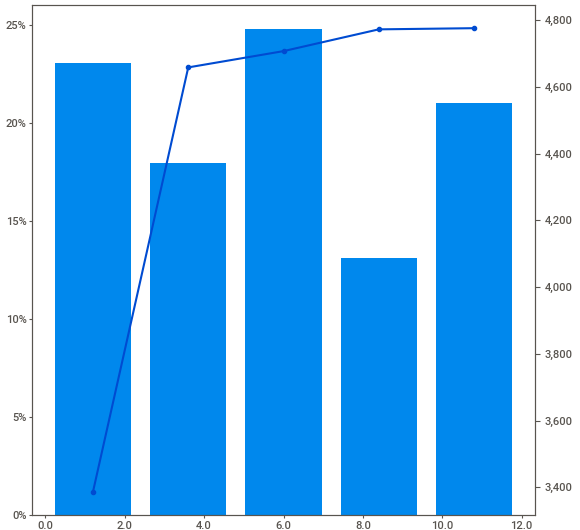
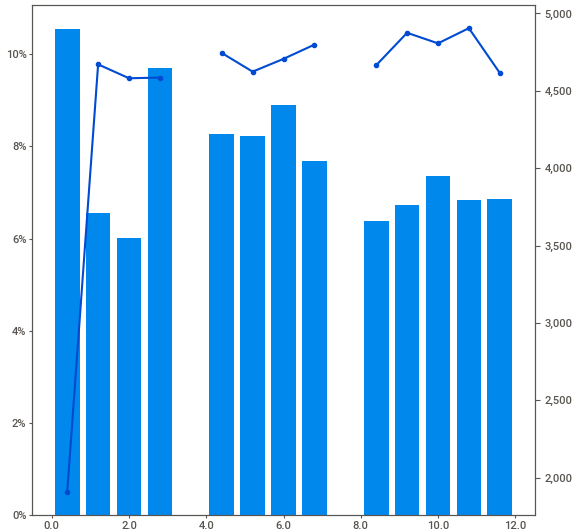
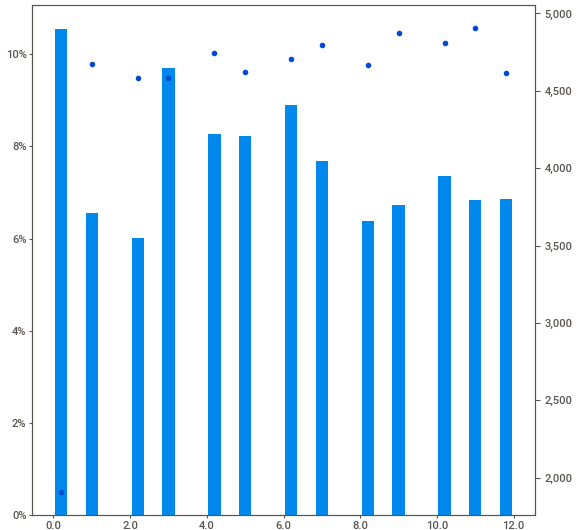
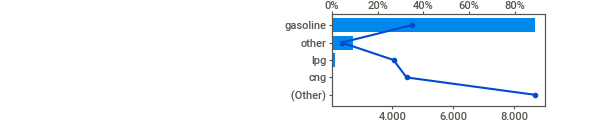
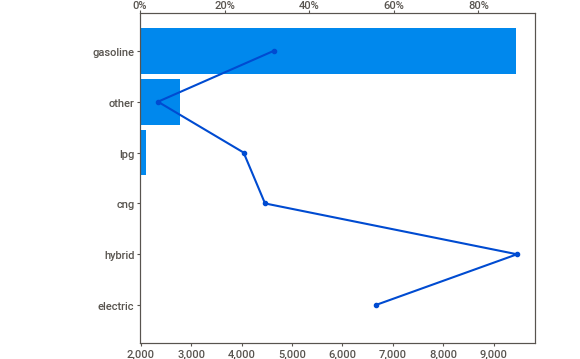
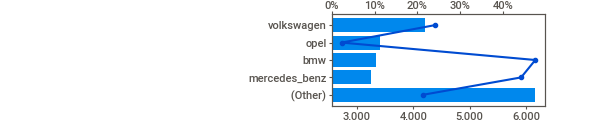
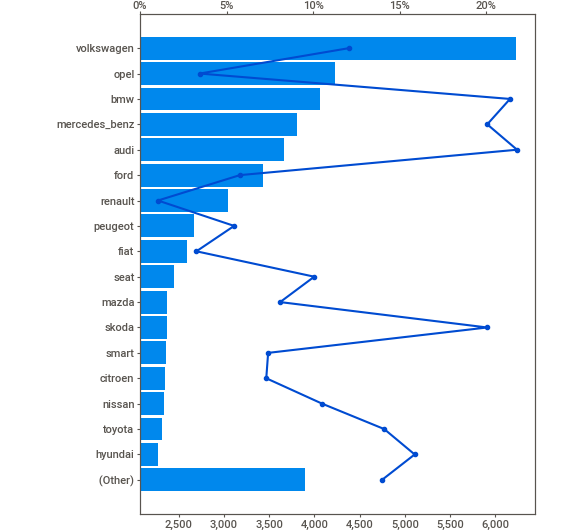
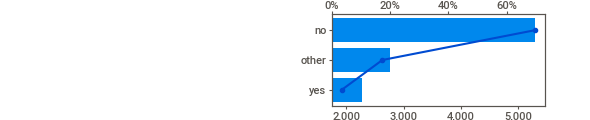
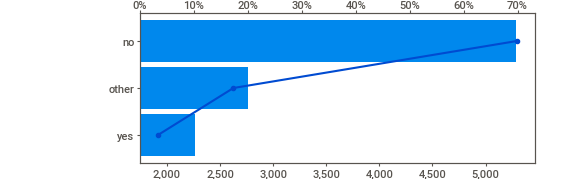
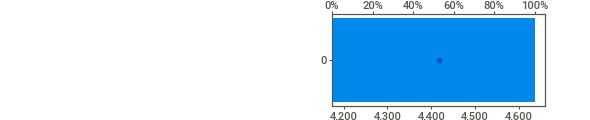
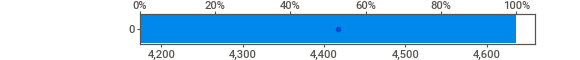
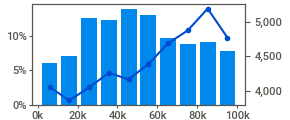
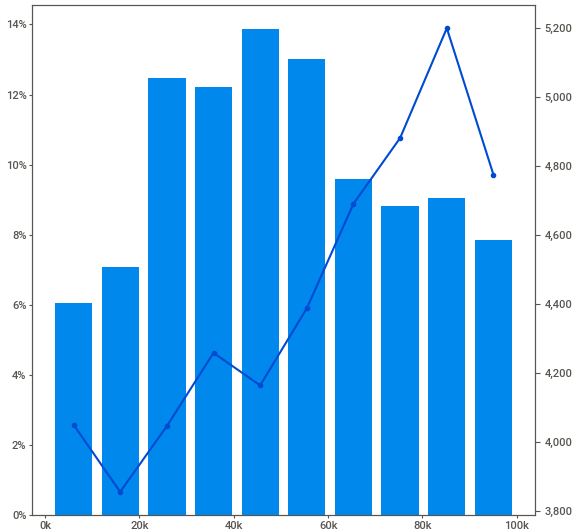
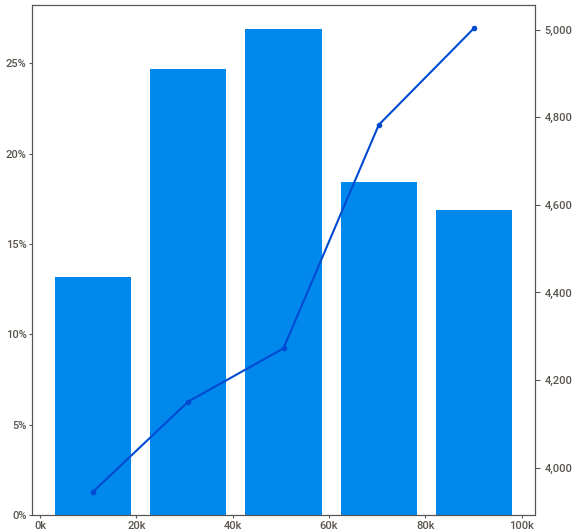
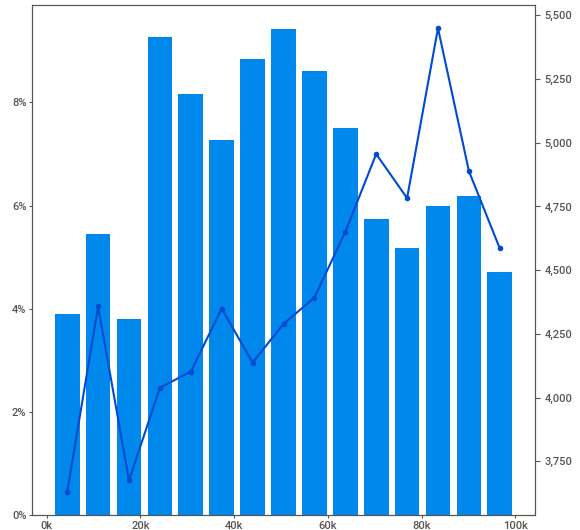
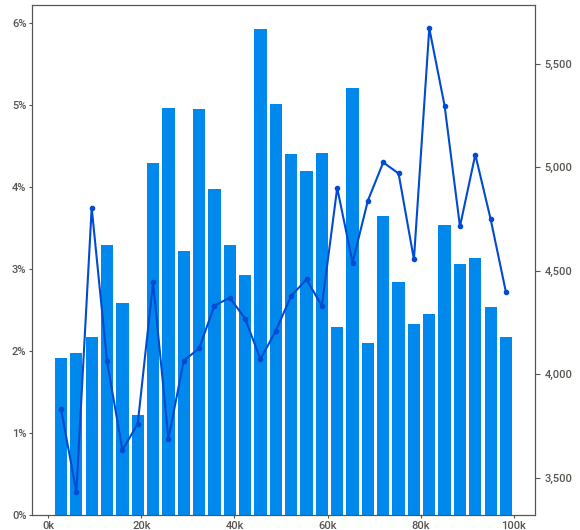
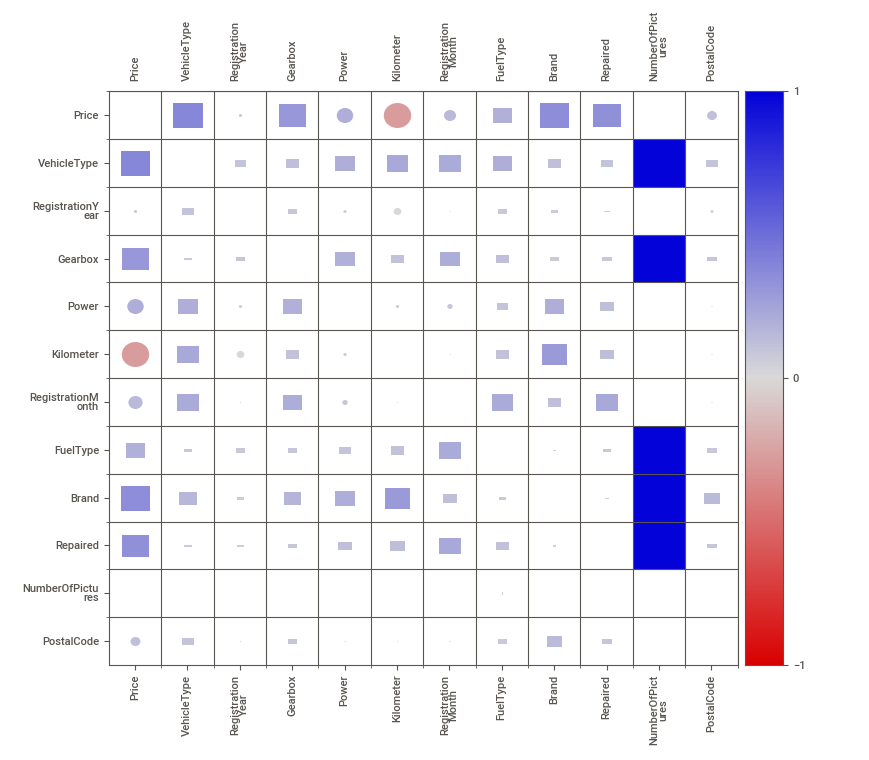
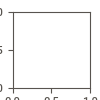

In [ ]:
report = sv.analyze(df, target_feat='Price')
report.show_notebook()

Обнаружены:
- нули и совсем малые значения в Price - принято решение удалить строки с значением цены меньше 50 евро
- выбросы и малые значения в Power -  принято решение заполнить медианой по группе  Model, если нет значений по группировке удалить
- нули в RegistrationMonth порядка 10,5% - принято решение оставить как есть.
- выбросы в RegistrationYear - принято решение удалить если немного, так как важный признак для прогнозирования цены.
- NumberOfPictures заполнен только нулями - принято решение удалить признак
- более 77% строк признака Kilometer принимает значение 125-150 тыс км - принято решение оставить как есть
- признаки 'DateCrawled', 'LastSeen', 'DateCreated' - все даты в 2016 году, не сильно влияет на таргет, принято решение удалить. При этом можно попробовать верифицироватиь год регистрации авто
- 'PostalCode' - принято решение удалить

In [ ]:
df.query('Price < 50')['Price'].count()

12423

In [ ]:
df = df.query('Price > 50')
df.query('Price < 50')['Price'].count()

0

<br/>
<div class="alert alert-info">
Исправил
   
</div>

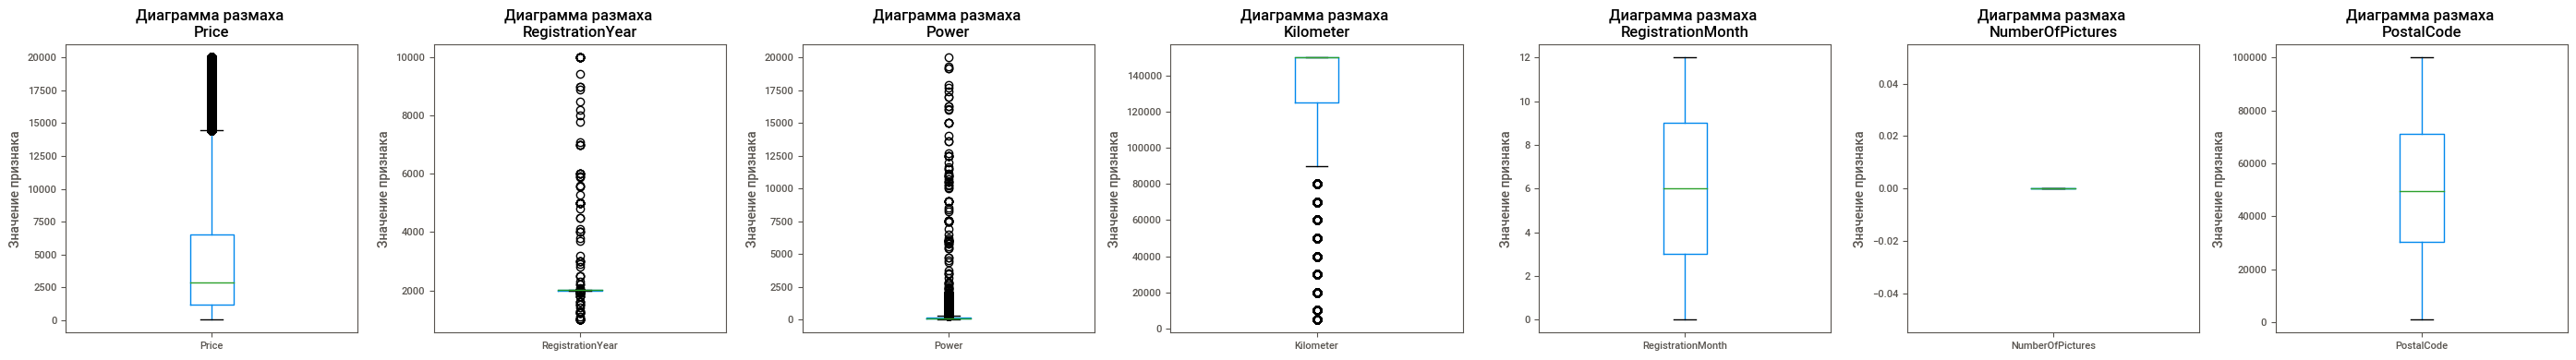

In [ ]:
def show_box(data, num_columns=None):
    if num_columns is None:
        num_columns = data.select_dtypes(include=['int', 'float']).columns

    plt.figure(figsize=(4 * len(num_columns), 4))

    for i, column in enumerate(num_columns):
        plt.subplot(1, len(num_columns), i + 1)
        data[column].plot(kind='box')
        plt.title('Диаграмма размаха \n' + column)
        plt.ylabel('Значение признака')

    plt.tight_layout()
    plt.show()

show_box(df)

In [ ]:
df.query('Power > 500 or Power<40')['Power'].count()

37123

Можно заменить часть аномальных значений в признаке power меданой значения power по группировке model

In [ ]:
df_median_power_by_model = df.groupby('Model')['Power'].median()
def replace_power_with_median(row):

    if row['Power'] > 500 or row['Power'] < 40 and row['Model'] in df_median_power_by_model:
        return df_median_power_by_model[row['Model']]
    return row['Power']

df['Power'] = df.apply(replace_power_with_median, axis=1)

In [ ]:
df.query('Power > 500 or Power<40')['Power'].count()

594

осталось немного аномальных значений power, который можно удалить

In [ ]:
df.query('RegistrationYear>2016 or RegistrationYear<1950 ')['RegistrationYear'].count()

13849

In [ ]:
df = df.query('Power<500 and Power>40')
df = df.query('RegistrationYear<2017 and RegistrationYear>1950')
df.shape[0]/df_shape*100

92.23521244804145

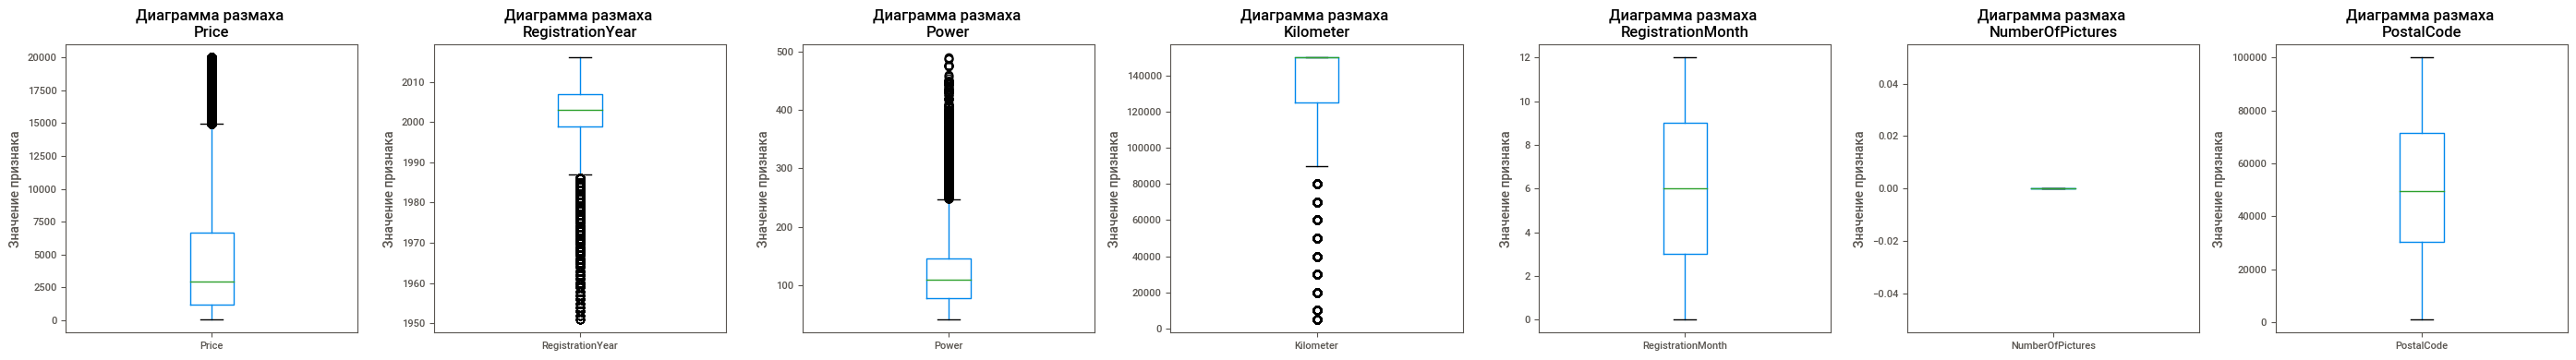

In [ ]:
show_box(df)

In [ ]:
df[df['DateCreated'].dt.year < df['RegistrationYear']]['DateCreated'].count()

0

проверил что нет строк, где RegistrationYear больше 'DateCreated'

'LastSeen','NumberOfPictures', 'DateCreated', 'DateCrawled', 'PostalCode' не несут дополнительной информации так как значения приходятся на 2016 год, приято решние их удалить

In [ ]:
df = df.drop(['LastSeen','NumberOfPictures', 'DateCreated', 'DateCrawled', 'PostalCode'], axis=1)
df.sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
127253,1900,sedan,1999,manual,101.0,golf,125000,6,gasoline,volkswagen,no
179944,2450,convertible,1995,manual,150.0,other,150000,2,gasoline,audi,no
205371,5300,small,2007,manual,80.0,corsa,70000,3,gasoline,opel,no
350002,6000,sedan,1991,manual,136.0,other,150000,12,gasoline,mercedes_benz,no
81966,2499,sedan,1998,manual,150.0,5er,150000,6,gasoline,bmw,other


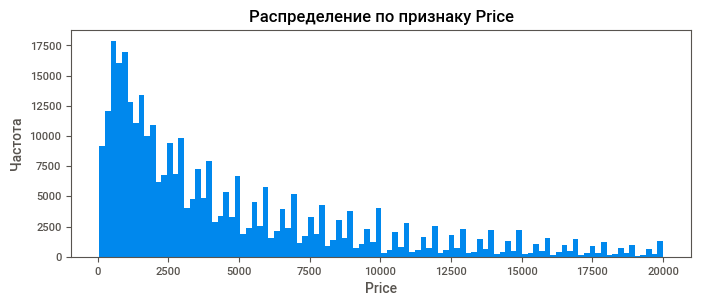

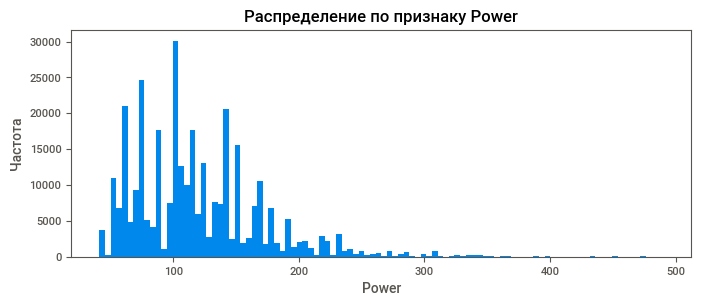

In [ ]:
num_columns = ['Price', 'Power']

def show_hist(data, num_columns=None):
    if num_columns is None:
        num_columns = data.select_dtypes(include=['int', 'float'])

    for column in num_columns:
        data[column].plot(kind='hist', bins=100, figsize=(8,3));
        plt.title('Распределение по признаку '+ column)
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.show()


show_hist(df, num_columns)

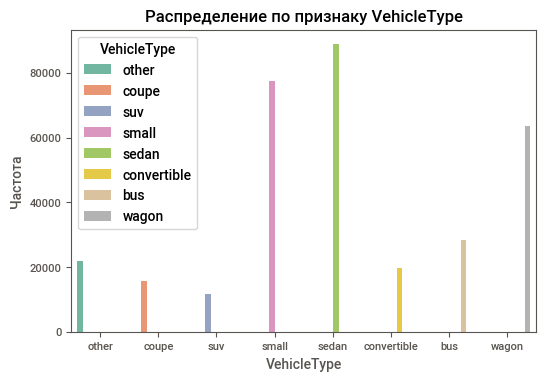

sedan          0.271902
small          0.236574
wagon          0.194075
bus            0.086473
other          0.067183
convertible    0.060354
coupe          0.047517
suv            0.035921
Name: VehicleType, dtype: float64


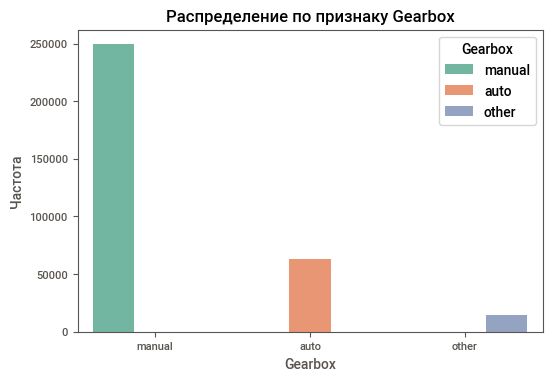

manual    0.763343
auto      0.191985
other     0.044671
Name: Gearbox, dtype: float64


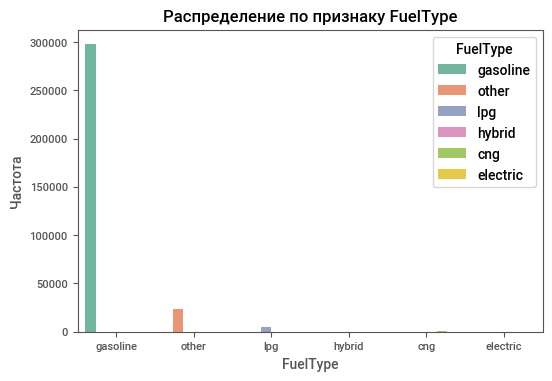

gasoline    0.911085
other       0.071041
lpg         0.015328
cng         0.001618
hybrid      0.000667
electric    0.000260
Name: FuelType, dtype: float64


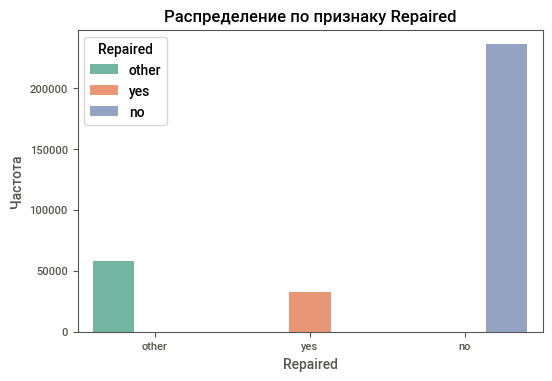

no       0.722208
other    0.178493
yes      0.099298
Name: Repaired, dtype: float64


In [ ]:
cat_columns = [
    'VehicleType',
    'Gearbox',
#     'Model',
    'FuelType',
#     'Brand',
    'Repaired'
]

def show_bar(data, cat_columns=None):
    if cat_columns is None:
        cat_columns = data.select_dtypes(include=['category', 'object'])

    for column in cat_columns:
        sns.countplot(x=column, data=data, palette='Set2', hue=column);
        plt.title('Распределение по признаку '+ column)
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.show()
        print(data[column].value_counts(normalize=True));

show_bar(df, cat_columns)

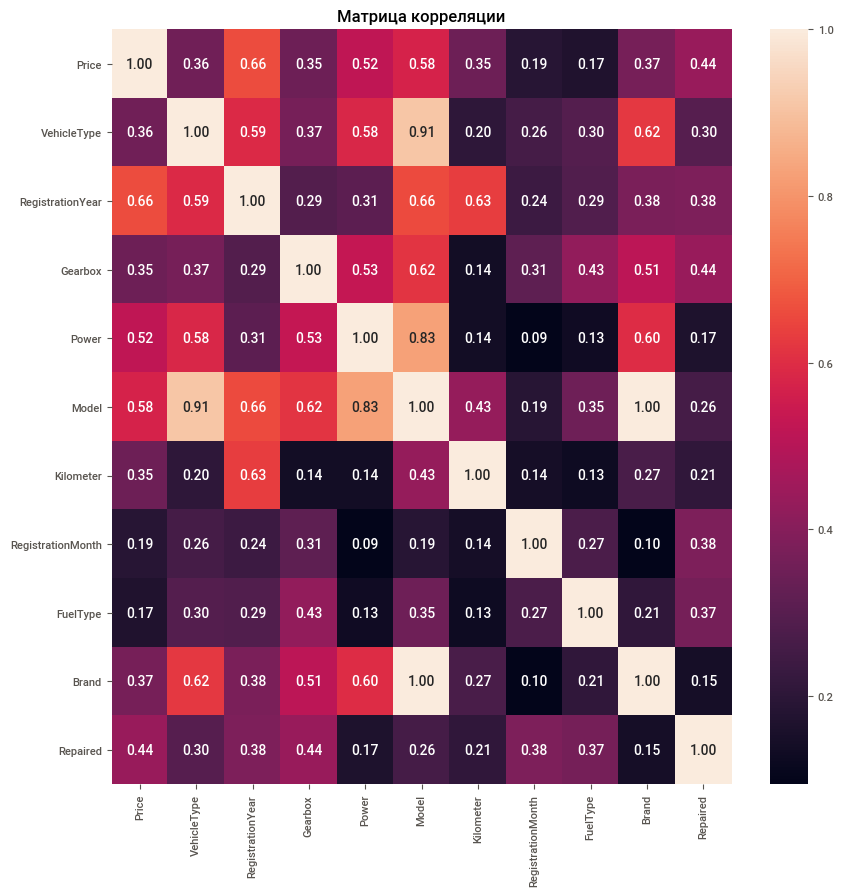

In [ ]:

plt.figure(figsize=(10, 10))
sns.heatmap(df.phik_matrix(interval_cols=num_columns, bins=20), annot=True, fmt='.2f');
plt.title('Матрица корреляции')
plt.show()

Наблюдается мультколлениарность признаков модель и бренд. У признака модель более сильная корреляция с таргетом, удалим признак бренд. При этом можно заполнить в признаке Модель значение other значением признака Бренд


In [ ]:
df[df['Model'] == 'other']['Model'] .count()

38096

Принято решение перед удалением признака 'Brand' заполнить в 'Model' значение other значением из признака 'Brand'

In [ ]:
def replace_model_with_brand(row):

    if row['Model'] == 'other':
        return row['Brand']
    return row['Model']

df['Model'] = df.apply(replace_model_with_brand, axis=1)
df[df['Model'] == 'other']['Model'] .count()

0

In [ ]:
df.drop('Brand', axis=1, inplace=True)

In [ ]:
df.duplicated().sum()

25895

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [ ]:
df.shape[0]/df_shape

0.8492785768506839

#### Выводы по разделу "Исследовательский анализ данных"

1. **Обработка пропусков и выбросов**:
   - **Малые значения в столбце Price** были удалены, так как они могут указывать на некорректные или отсутствующие данные.
   - **Выбросы в столбце Power** были заменены на медиану по группе **Model**, остальные удалены
   - **Выбросы в столбце RegistrationYear** были удалены, поскольку они существенно отклонялись от нормальных значений и могли влиять на модель.
   
   
2. **Удаление ненужных признаков**:
   - Признаки **'DateCrawled'**, **'LastSeen'**, **'DateCreated'**, **'NumberOfPictures'**, **'PostalCode'** были удалены, так как они не предоставляют значимой информации для прогнозирования, что помогает улучшить производительность модели и снизить её сложность.
   

3. **Обработка мультиколлинеарных признаков**:
   - Признак **'Brand'** был удален, так как он был мультиколлинеарен с признаком **'Model'**. Для сохранения информации был предварительно заполнен значение other в столбце **'Model'** значением из столбца **'Brand'**.
   

4. **Обработка явных дубликатов**:
    - После всех операций удалены явные дубли в данных

### Обучение моделей

#### Кросс-валидация моделей

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Price'], axis=1),
    df['Price'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

In [ ]:
ohe_columns = [
    'VehicleType',
    'Gearbox',
    'Model',
    'FuelType',
    'Repaired',
    ]
ord_columns = [
    'RegistrationMonth',
    ]
num_columns = [
    'Power',
    'RegistrationYear',
    'Kilometer',

    ]

In [ ]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop=None, handle_unknown='ignore'))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler() , num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', RandomForestRegressor())
])

param_grid = [
    # Словарь для модели RandomForestRegressor
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [5, 6],
        'models__n_estimators': [50, 100],
#         'models__min_samples_split': [2, 5],
#         'models__min_samples_leaf': [1, 2],
#         'preprocessor__num': [StandardScaler(), 'passthrough']
    },

    # Словарь для модели LinearRegression
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # Словарь для модели SVR (Support Vector Regressor)
#     {
#         'models': [SVR()],
#         'models__C': [0.1, 1, 10],
#         'models__kernel': ['linear', 'rbf', 'poly'],
#         'models__gamma': ['scale', 'auto'],
#         'models__epsilon': [0.1, 0.2, 0.5],
#         'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
#     },

    # Словарь для модели LightGBM (Gradient Boosting)
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__num_leaves': [31, 70],
        'models__max_depth': [ 5, 10],
#         'models__learning_rate': [0.01, 0.1, 0.2],
#         'models__n_estimators': [50, 100, 200],
#         'models__subsample_for_bin': [200000, 300000],
#         'models__min_data_in_leaf': [20, 30],
#         'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

In [ ]:
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=rmse_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [ ]:
%%time

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

randomized_search.fit(X_train, y_train)

best_model = randomized_search.best_estimator_

print('Лучшая модель и её параметры:\n\n', best_model)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType',
                                                   'Repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   Simp

In [ ]:
result = pd.DataFrame(randomized_search.cv_results_).sort_values('rank_test_score')
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models,param_models__n_estimators,param_models__max_depth,param_models__num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,5.998728,0.326106,0.458126,0.043057,NaN,"LGBMRegressor(max_depth=10, num_leaves=70, ran...",NaN,10,70,"{'models__num_leaves': 70, 'models__max_depth'...",-1707.862328,-1705.933910,-1710.944696,-1730.350145,-1717.940914,-1714.606399,8.866647,1
2,4.800428,0.607790,0.405696,0.001728,NaN,"LGBMRegressor(max_depth=10, num_leaves=70, ran...",NaN,10,31,"{'models__num_leaves': 31, 'models__max_depth'...",-1750.049910,-1747.878358,-1753.834927,-1777.957136,-1758.512568,-1757.646580,10.778914,2
8,4.126272,0.378304,0.340129,0.043945,NaN,"LGBMRegressor(max_depth=10, num_leaves=70, ran...",NaN,5,31,"{'models__num_leaves': 31, 'models__max_depth'...",-1814.504864,-1812.589222,-1821.495647,-1840.959161,-1824.558175,-1822.821414,10.075859,3
6,3.835136,0.352444,0.321198,0.035297,NaN,"LGBMRegressor(max_depth=10, num_leaves=70, ran...",NaN,5,70,"{'models__num_leaves': 70, 'models__max_depth'...",-1815.779940,-1812.668680,-1825.895876,-1844.327070,-1828.550356,-1825.444384,11.162677,4
4,28.770315,0.230522,0.197126,0.008677,NaN,RandomForestRegressor(random_state=42),50,6,NaN,"{'models__n_estimators': 50, 'models__max_dept...",-2237.173788,-2229.749507,-2243.418416,-2258.451647,-2250.763935,-2243.911459,10.045633,5
9,55.832377,0.182033,0.309592,0.004089,NaN,RandomForestRegressor(random_state=42),100,6,NaN,"{'models__n_estimators': 100, 'models__max_dep...",-2238.082603,-2228.928603,-2245.798214,-2256.243799,-2250.783936,-2243.967431,9.605449,6
1,19.193990,0.231565,0.184782,0.004027,NaN,RandomForestRegressor(random_state=42),50,5,NaN,"{'models__n_estimators': 50, 'models__max_dept...",-2381.078643,-2385.854473,-2400.204437,-2422.880616,-2421.948095,-2402.393253,17.520038,7
5,36.470630,0.178450,0.276143,0.003565,NaN,RandomForestRegressor(random_state=42),100,5,NaN,"{'models__n_estimators': 100, 'models__max_dep...",-2383.817792,-2389.247436,-2405.822422,-2421.764138,-2424.134526,-2404.957263,16.399164,8
0,23.415216,1.874823,0.228078,0.026303,MinMaxScaler(),LinearRegression(),NaN,NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models'...",-2679.148181,-2679.009124,-2678.513879,-2683.639523,-2682.512474,-2680.564636,2.091916,9
7,25.294271,1.923620,0.230134,0.031422,StandardScaler(),LinearRegression(),NaN,NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",-2679.154682,-2679.059222,-2678.549132,-2683.641017,-2682.506564,-2680.582123,2.076062,10


- Градиентный бустинг (LightGBM) продемонстрировал наилучшее качество
- Случайный лес (RandomForestRegressor) показал приемлемое качество по метрике RMSE<2600
- Линейная регрессия (LinearRegression) не прошла по критерию качества

Принято решение обучить градиентный бустинг и случайный лес для сравнения критерий установленных заказчиком

#### Обучение моделей

In [ ]:
def prepare_data(X_train, X_test):
    # создание списков с количественными и категориальными признаками
    cat_col_names = X_train.select_dtypes(exclude='number').columns.tolist()
    num_col_names = X_train.select_dtypes(include='number').columns.tolist()

    # создание класса OneHotEncoder() для кодирования
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')

    # кодирование категориальных признаков из тренировочной и тестовой выборок
    X_train_ohe = ohe.fit_transform(X_train[cat_col_names])
    X_test_ohe = ohe.transform(X_test[cat_col_names])


    # создание класса StandardScaler() для масштабирования
    scaler = StandardScaler()

    # масштабирование количественных признаков в тренировочной и тестовой выборках
    X_train[num_col_names] = scaler.fit_transform(X_train[num_col_names])
    X_test[num_col_names] = scaler.transform(X_test[num_col_names])


    # сохранение в переменной encoder_col_names списка названий новых столбцов
    encoder_col_names = ohe.get_feature_names()

    # создание датафрейма из закодированных данных
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)


    # обнуление индексов строк перед объединением количественных и категориальных признаков в датафрейм
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()


    # объединение датафреймов
    X_train = pd.concat((X_train[num_col_names], X_train_ohe), axis=1)
    X_test = pd.concat((X_test[num_col_names], X_test_ohe), axis=1)

    return X_train, X_test


X_train, X_test = prepare_data(X_train, X_test)

In [ ]:
result.iloc[0]['params']

{'models__num_leaves': 70,
 'models__max_depth': 10,
 'models': LGBMRegressor(max_depth=10, num_leaves=70, random_state=42)}

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)

test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'models__num_leaves': 70,
    'models__max_depth': 10,
}

In [ ]:
%%time

lgb_model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data],
    num_boost_round=100,
)

[LightGBM] [Warning] Unknown parameter: models__max_depth
[LightGBM] [Warning] Unknown parameter: models__num_leaves
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.106746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 225718, number of used features: 293
[LightGBM] [Info] Start training from score 4623.535567
[1]	training's l2: 1.7928e+07
[2]	training's l2: 1.56051e+07
[3]	training's l2: 1.36554e+07
[4]	training's l2: 1.20706e+07
[5]	training's l2: 1.07848e+07
[6]	training's l2: 9.65777e+06
[7]	training's l2: 8.74496e+06
[8]	training's l2: 7.98524e+06
[9]	training's l2: 7.35537e+06
[10]	training's l2: 6.81844e+06
[11]	training's l2: 6.38337e+06
[12]	training's l2: 6.00097e+06
[13]	training's l2: 5.68615e+06
[14]	training's l2: 5.42395e+06
[15]	training's l2: 5.19139e+06


In [ ]:
%%time
y_pred = lgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'RMSE: {rmse}')

RMSE: 1728.9823501976177
CPU times: user 1 s, sys: 165 ms, total: 1.17 s
Wall time: 1.2 s


In [ ]:
result.iloc[4]['params']

{'models__n_estimators': 50,
 'models__max_depth': 6,
 'models': RandomForestRegressor(random_state=42)}

In [ ]:
model = RandomForestRegressor(
    n_estimators=50,
    max_depth=6
)

In [ ]:
%%time
model.fit(X_train, y_train)

CPU times: user 1min 23s, sys: 117 ms, total: 1min 23s
Wall time: 1min 23s


RandomForestRegressor(max_depth=6, n_estimators=50)

In [ ]:
%%time
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'RMSE: {rmse}')


RMSE: 2256.0451545058418
CPU times: user 244 ms, sys: 135 ms, total: 380 ms
Wall time: 377 ms


### Выводы по проекту

В ходе выполнения проекта были обучены и протестированы четыре модели регрессии:

1. **Градиентный бустинг (LightGBM)**  
2. **Линейная регрессия (LinearRegression)**   
3. **Случайный лес (RandomForestRegressor)**

Результаты по критерию качества следующие:

- **Градиентный бустинг (LightGBM)** продемонстрировал наилучшее качество с метрикой RMSE 1730, что является наилучшим результатом среди протестированных моделей.
- **Моделm линейной регрессии** не прошла по метрике RMSE (метрика должна быть меньше 2500).
- **Случайный лес (RandomForestRegressor)** показал приемлемое качество по метрике RMSE, однако он уступает градиентному бустингу по времени обучения и времени предсказания.

Результаты по критерию время обучения и время предсказания модели:
-  **Градиентный бустинг (LightGBM)** показал лучшее время обучения модели, чем **Случайный лес (RandomForestRegressor)**
-  **Случайный лес (RandomForestRegressor)** показал лучшее время предсказания модели, чем **Градиентный бустинг (LightGBM)**

Рекомендации заказчику:

- Если основная цель — качество предсказаний, то следует использовать градентный бустинг (LightGBM).
- Если задача требует быстрой обработки и обучения моделей на больших данных, то градентный бустинг (LightGBM) будет предпочтительнее.
- Если приоритет — быстрота предсказаний, то предпочтительнее Случайный лес (RandomForestRegressor), который быстрее выполняет предсказания.
